In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:  tf.config.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:  print(e)

import numpy as np
import h5py
import matplotlib.pyplot as plt
import json
from PIL import Image


from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image


In [2]:
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Flatten the 28x28 images into vectors of 784 elements
x_train = x_train.reshape(-1, 28 * 28).astype('float32') / 255
x_test = x_test.reshape(-1, 28 * 28).astype('float32') / 255

# Convert the labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
        
print(f"Shape of X_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (60000, 784)
Shape of y_train: (60000, 10)
Shape of X_test: (10000, 784)
Shape of y_test: (10000, 10)


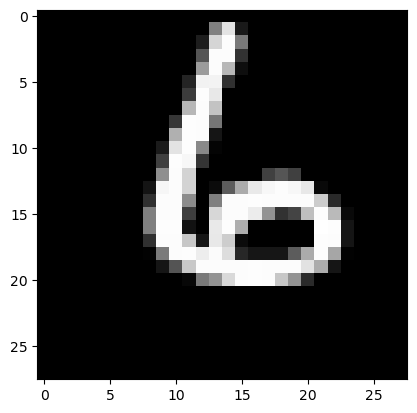

In [3]:
idx = np.random.randint(0, x_train.shape[0])
image = x_train[idx].reshape(28, 28)
label = y_train[idx]

plt.imshow(image, cmap='gray');

# Define model 

In [23]:
class CustomDense(tf.keras.layers.Layer):
    def __init__(self, n_in, n_out, activation=None):
        super(CustomDense, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # Initialize weights and bias
        self.w = self.add_weight(shape=(self.n_in, self.n_out), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(self.n_out,), initializer='random_normal', trainable=True)

    def call(self, inputs):
        z = tf.matmul(inputs, self.w) + self.b  
        if self.activation:
            z = self.activation(z)  
        return z  
    

In [25]:
# Model Configuration
input_size = 784
hidden_layer_size = 128
output_size = 10

# Building the Fully Connected Neural Network
tf.keras.backend.clear_session()
model = Sequential([
    CustomDense(n_in=input_size, n_out=hidden_layer_size),  
    layers.Activation('relu'),
    CustomDense(n_in=hidden_layer_size, n_out=output_size),
    layers.Activation('softmax'),
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [26]:
# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/5
1875/1875 [==============================] - 2s 729us/step - loss: 0.2906 - accuracy: 0.9187 - val_loss: 0.1469 - val_accuracy: 0.9573
Epoch 2/5
1875/1875 [==============================] - 1s 683us/step - loss: 0.1248 - accuracy: 0.9629 - val_loss: 0.1043 - val_accuracy: 0.9682
Epoch 3/5
1875/1875 [==============================] - 1s 675us/step - loss: 0.0843 - accuracy: 0.9752 - val_loss: 0.0862 - val_accuracy: 0.9739
Epoch 4/5
1875/1875 [==============================] - 1s 682us/step - loss: 0.0612 - accuracy: 0.9815 - val_loss: 0.0770 - val_accuracy: 0.9762
Epoch 5/5
1875/1875 [==============================] - 1s 684us/step - loss: 0.0484 - accuracy: 0.9852 - val_loss: 0.0758 - val_accuracy: 0.9762
313/313 - 0s - loss: 0.0758 - accuracy: 0.9762 - 164ms/epoch - 522us/step
Test accuracy: 0.9762


# Save trained weight into `txt` format.

In [27]:
PATH_WEIGHT_FOLDER = r"weight"

weights = model.get_weights()

In [29]:
len(weights)

4

In [30]:
# Save layer 1 (weights and biases)
np.savetxt(os.path.join(PATH_WEIGHT_FOLDER, 'hidden_weights.txt'), weights[0].flatten(), fmt='%f', delimiter=' ')
np.savetxt(os.path.join(PATH_WEIGHT_FOLDER, 'hidden_bias.txt'), weights[1], fmt='%f', delimiter=' ')

# Save layer 2 (weights and biases)
np.savetxt(os.path.join(PATH_WEIGHT_FOLDER, 'output_weights.txt'), weights[2].flatten(), fmt='%f', delimiter=' ')
np.savetxt(os.path.join(PATH_WEIGHT_FOLDER, 'output_bias.txt'), weights[3], fmt='%f', delimiter=' ')

print("Weights and biases saved to separate .txt files.")

Weights and biases saved to separate .txt files.


# Run inference

In [31]:
input_image_path = 'image/digit_gray.jpg'

img = image.load_img(input_image_path, target_size=(28, 28), color_mode="grayscale")
img_array = image.img_to_array(img)
img_array = img_array / 255.0  
img_array = np.reshape(img_array, (1, 784))  # Flatten the image to shape (1, 784)

In [32]:
prediction = model.predict(img_array)[0]

print("Model Inference (Softmax Probabilities):", prediction)
print("Predicted Digit:", np.argmax(prediction))
print(f"Predicted Digit Probability: {prediction[np.argmax(prediction)]:.4f}")

1/1 [==============================] - 0s 18ms/step
Model Inference (Softmax Probabilities): [4.1252638e-13 9.5248961e-16 9.9651015e-07 1.6341355e-06 6.5210619e-23
 1.3017629e-03 2.1087857e-15 9.9869567e-01 5.7997686e-18 1.0085674e-19]
Predicted Digit: 7
Predicted Digit Probability: 0.9987


# Convert image to grayscale for inference

In [9]:
input_image_path = 'image/digit.jpg'  
image = Image.open(input_image_path)

gray_image = image.convert('L')

resized_image = gray_image.resize((28, 28))

# Save the resulting image
output_image_path = 'image/digit_gray.jpg'
resized_image.save(output_image_path)